In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import hilbert, resample
from scipy.fft import rfft
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.manifold import TSNE
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [ ]:
# ======================================================================================
# 1. PRE-PROCESSING: ENVELOPE & FFT (High Resolution)
# ======================================================================================
class UOSPreProcessor:
    def __init__(self, root_dir, bearing_type, target_spr=400, segment_len_rev=10, output_len=2048):
        self.root_dir = root_dir
        self.bearing_type = bearing_type
        self.target_spr = target_spr
        self.window_size = int(target_spr * segment_len_rev) # 4000 points
        self.output_len = output_len # 2048 points

    def angular_resampling(self, signal, fs, rpm):
        duration = len(signal) / fs
        total_revolutions = (rpm / 60.0) * duration
        new_length = int(total_revolutions * self.target_spr)
        if new_length > 0:
            return resample(signal, new_length)
        return np.zeros(self.window_size)

    def extract_features(self, segment):
        # --- Envelope Spectrum ---
        analytic_signal = hilbert(segment)
        envelope = np.abs(analytic_signal) - np.mean(np.abs(analytic_signal))
        env_spec = np.abs(rfft(envelope, n=self.window_size)) / len(envelope)
        
        # --- FFT Spectrum ---
        fft_spec = np.abs(rfft(segment, n=self.window_size)) / len(segment)
        
        # Cắt/pad dữ liệu
        def process_spec(spec):
            if len(spec) >= self.output_len: 
                return spec[:self.output_len]
            return np.pad(spec, (0, self.output_len - len(spec)))

        env_feat = process_spec(env_spec)
        fft_feat = process_spec(fft_spec)

        # Log-Scale (dB)
        env_feat = 20 * np.log10(env_feat + 1e-6)
        fft_feat = 20 * np.log10(fft_feat + 1e-6)
        
        # Normalization
        env_feat = (env_feat - np.median(env_feat)) / 20.0
        fft_feat = (fft_feat - np.median(fft_feat)) / 20.0
        

    def process_all_speeds(self, speeds_list, fs_folder='SamplingRate_16000'):
        data = {'env': [], 'fft': [], 'label': []}
        base_path = os.path.join(self.root_dir, self.bearing_type, fs_folder)
        
        # Mapping nhãn: [Ball, IR, OR, U, M, L]
        bearing_map = {'B': 0, 'IR': 1, 'OR': 2} 
        mech_map = {'U': 3, 'M': 4, 'L': 5} 

        print(f"--- Đang xử lý dữ liệu {self.bearing_type} (Gộp các tốc độ: {speeds_list}) ---")
        
        for speed in speeds_list:
            speed_path = os.path.join(base_path, f"RotatingSpeed_{speed}")
            if not os.path.exists(speed_path): continue
            
            files = [f for f in os.listdir(speed_path) if f.endswith('.mat')]
            for f_name in tqdm(files, desc=f"Speed {speed}"):
                try:
                    parts = f_name.split('_') # VD: M1_OR_16_...
                    mech_raw, bear_raw = parts[0], parts[1]
                    
                    # Gộp nhãn lỗi cơ khí (U1, U2 -> U)
                    if mech_raw == 'H': mech_key = 'H'
                    elif mech_raw == 'L': mech_key = 'L'
                    else: mech_key = mech_raw[0] 
                    
                    # Tạo vector One-Hot 6 chiều
                    label_vec = np.zeros(6, dtype=np.float32)
                    if bear_raw in bearing_map: label_vec[bearing_map[bear_raw]] = 1.0
                    if mech_key in mech_map: label_vec[mech_map[mech_key]] = 1.0

                    # Load và Resample
                    mat = sio.loadmat(os.path.join(speed_path, f_name))
                    raw = mat['Data'].flatten() if 'Data' in mat else mat['data'].flatten()
                    sig = self.angular_resampling(raw, 16000, speed)
                    
                    # Segment (Lấy tối đa 50 mẫu/file cho nhẹ RAM)
                    step = self.window_size // 2
                    n_segs = min((len(sig) - self.window_size) // step, 50)
                    
                    for i in range(n_segs):
                        seg = sig[i*step : i*step + self.window_size]
                        e, f = self.extract_features(seg)
                        data['env'].append(e)
                        data['fft'].append(f)
                        data['label'].append(label_vec)
                except: pass
                
        return {k: np.array(v) for k, v in data.items()}


# --- 1. Hàm tạo nhiễu Gauss AWGN ---
def add_white_gaussian_noise(signal, snr_db):
    """
    SNR = 10 * log10(P_signal / P_noise)
    """
    P_signal = np.mean(signal ** 2)
    P_noise = P_signal / (10 ** (snr_db / 10.0))
    noise = np.random.normal(0, np.sqrt(P_noise), len(signal))
    return signal + noise

# --- 2. Class xử lý dữ liệu nhiễu (Kế thừa từ class cũ) ---
class NoisyUOSPreProcessor(UOSPreProcessor):
    def process_test_data_with_noise(self, speeds_list, snr_db, fs_folder='SamplingRate_16000'):
        """
        Load dữ liệu, thêm nhiễu vào raw signal, sau đó mới trích xuất đặc trưng.
        """
        data = {'env': [], 'fft': [], 'label': []}
        base_path = os.path.join(self.root_dir, self.bearing_type, fs_folder)
        
        bearing_map = {'B': 0, 'IR': 1, 'OR': 2} 
        mech_map = {'U': 3, 'M': 4, 'L': 5} 

        # Chỉ lấy 20% số lượng file hoặc segment để test cho nhanh (Optional)
        # Ở đây tôi để chạy full nhưng limit segment
        
        for speed in speeds_list:
            speed_path = os.path.join(base_path, f"RotatingSpeed_{speed}")
            if not os.path.exists(speed_path): continue
            
            # Lấy danh sách file (chỉ lấy 1 phần để test nhanh nếu muốn)
            files = [f for f in os.listdir(speed_path) if f.endswith('.mat')]
            
            for f_name in files:
                try:
                    parts = f_name.split('_')
                    mech_raw, bear_raw = parts[0], parts[1]
                    
                    if mech_raw == 'H': mech_key = 'H'
                    elif mech_raw == 'L': mech_key = 'L'
                    else: mech_key = mech_raw[0] 
                    
                    label_vec = np.zeros(6, dtype=np.float32)
                    if bear_raw in bearing_map: label_vec[bearing_map[bear_raw]] = 1.0
                    if mech_key in mech_map: label_vec[mech_map[mech_key]] = 1.0

                    mat = sio.loadmat(os.path.join(speed_path, f_name))
                    raw = mat['Data'].flatten() if 'Data' in mat else mat['data'].flatten()
                    sig = self.angular_resampling(raw, 16000, speed)
                    
                    step = self.window_size // 2
                    # Giới hạn 20 segments/file để test nhanh
                    n_segs = min((len(sig) - self.window_size) // step, 20)
                    
                    for i in range(n_segs):
                        seg = sig[i*step : i*step + self.window_size]
                        
                        # >>> QUAN TRỌNG: THÊM NHIỄU TẠI ĐÂY <<<
                        noisy_seg = add_white_gaussian_noise(seg, snr_db)
                        
                        # Sau đó mới tính Envelope/FFT trên tín hiệu nhiễu
                        e, f = self.extract_features(noisy_seg)
                        
                        data['env'].append(e)
                        data['fft'].append(f)
                        data['label'].append(label_vec)
                except: pass
                
        return {k: np.array(v) for k, v in data.items()}
    

def run_noise_robustness_test(clean_models, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Danh sách SNR cần test
    snr_list = [10, 5, 0, -4, -8] 
    
    # Lưu kết quả F1-Score (Macro Average)
    results = {name: [] for name in clean_models.keys()}
    
    processor = NoisyUOSPreProcessor(config['root_dir'], config['bearing_name'])
    
    print("\n" + "="*60)
    print(" BẮT ĐẦU KIỂM THỬ ĐỘ BỀN VỮNG VỚI NHIỄU (NOISE ROBUSTNESS) ")
    print("="*60)
    
    for snr in snr_list:
        print(f"\n>>> Generating Test Data with SNR = {snr} dB ...")
        
        # 1. Tạo dữ liệu test nhiễu mới
        # Dùng toàn bộ tốc độ để test độ tổng quát
        noisy_data = processor.process_test_data_with_noise(config['all_speeds'], snr)
        
        # Tạo DataLoader
        ds = MultiLabelDataset(noisy_data['env'], noisy_data['fft'], noisy_data['label'])
        dl = DataLoader(ds, batch_size=config['batch_size'], shuffle=False)
        
        print(f"    Evaluating models on {len(ds)} noisy samples...")
        
        # 2. Test từng model
        for name, model in clean_models.items():
            model = model.to(device)
            model.eval()
            
            y_true, y_pred = [], []
            with torch.no_grad():
                for env, fft, lbl in dl:
                    env, fft = env.to(device), fft.to(device)
                    
                    # Forward
                    logits = model(env, fft)
                    probs = torch.sigmoid(logits)
                    preds = (probs > 0.5).float()
                    
                    y_true.extend(lbl.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
            
            # Tính Macro F1-Score
            _, _, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
            
            results[name].append(f1_macro)
            print(f"    -> Model {name:<15}: F1-Score = {f1_macro:.4f}")

    # --- 3. VẼ BIỂU ĐỒ SO SÁNH ---
    plot_noise_results(snr_list, results)

def plot_noise_results(snr_list, results):
    plt.figure(figsize=(10, 7))
    
    markers = ['o', 's', '^']
    colors = ['mediumseagreen', 'indianred', 'royalblue']
    
    for (name, scores), marker, color in zip(results.items(), markers, colors):
        plt.plot(snr_list, scores, marker=marker,  linewidth=2.5, markersize=8, label=name, color=color)
    
    plt.title('Model Robustness against Additive Noise', fontsize=16, fontweight='bold')
    plt.xlabel('Signal-to-Noise Ratio (SNR) [dB]', fontsize=12)
    plt.ylabel('Macro F1-Score', fontsize=12)
    
    # Đảo trục X để SNR giảm dần từ trái sang phải
    plt.gca().invert_xaxis()
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=11)
    plt.ylim(0, 1.05)
    
    # Thêm chú thích
    plt.text(snr_list[0], 0.05, 'Less Noise', ha='center', va='bottom', fontsize=10, color='gray')
    plt.text(snr_list[-1], 0.05, 'Heavy Noise', ha='center', va='bottom', fontsize=10, color='gray')
    
    plt.show()

In [ ]:
# ======================================================================================
# 2. MODEL ARCHITECTURE: DUAL-STREAM + CBAM + ATTENTION HEAD
# ======================================================================================

# --- Block A: CBAM (Channel & Spatial Attention cho Backbone) ---
class CBAM1D(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM1D, self).__init__()
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()
        # Spatial Attention
        self.conv_spatial = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        # Channel Attn
        b, c, l = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c)).view(b, c, 1)
        max_out = self.fc(self.max_pool(x).view(b, c)).view(b, c, 1)
        scale_c = self.sigmoid_channel(avg_out + max_out)
        x = x * scale_c
        # Spatial Attn
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        scale_s = self.sigmoid_spatial(self.conv_spatial(torch.cat([avg_out, max_out], dim=1)))
        return x * scale_s

# --- Block B: Backbone Deep CNN (5 Layers) ---
class DeepBackbone(nn.Module):
    def __init__(self, kernel_size_first=64, stride_first=4):
        super().__init__()
        def conv_bn_relu(in_c, out_c, k, s, p, pool=True):
            layers = [nn.Conv1d(in_c, out_c, k, s, p), nn.BatchNorm1d(out_c), nn.ReLU()]
            if pool: layers.append(nn.MaxPool1d(2))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            conv_bn_relu(1, 16, kernel_size_first, stride_first, kernel_size_first//2),
            conv_bn_relu(16, 32, 3, 1, 1),
            conv_bn_relu(32, 64, 3, 1, 1),
            conv_bn_relu(64, 128, 3, 1, 1),
            conv_bn_relu(128, 256, 3, 1, 1, pool=False) # Giữ lại chiều dài ở lớp cuối
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.cbam = CBAM1D(channels=256) # Tích hợp CBAM

    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x) # Apply Attention
        x = self.global_pool(x)
        return x.flatten(1) # (Batch, 256)

# --- Block C: Classifier Attention Head (SE-Style) ---
class AttentionClassifierHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        # Khối Attention để "chọn lọc" đặc trưng trước khi phân loại
        self.attention = nn.Sequential(
            nn.Linear(input_dim, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, input_dim),
            nn.Sigmoid()
        )
        # Bộ phân loại chính
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x shape: (Batch, 512)
        attn_weights = self.attention(x)
        x_weighted = x * attn_weights # Feature Refinement
        return self.classifier(x_weighted)

# --- Main Model: Full Fusion ---
class AttentionFusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Nhánh 1: Envelope (Kernel nhỏ để bắt xung)
        self.env_backbone = DeepBackbone(kernel_size_first=9, stride_first=2)
        # Nhánh 2: FFT (Kernel lớn để bắt tần số thấp)
        self.fft_backbone = DeepBackbone(kernel_size_first=64, stride_first=4)
        
        # Fusion & Classification
        fusion_dim = 256 + 256 # 512
        self.head = AttentionClassifierHead(fusion_dim, 6) # 6 Class Multi-label

    def forward(self, x_env, x_fft):
        f_env = self.env_backbone(x_env)
        f_fft = self.fft_backbone(x_fft)
        f_cat = torch.cat([f_env, f_fft], dim=1) # Ghép đặc trưng
        return self.head(f_cat)
    

# --- Mô hình Single-Branch (Dùng cho ablation study) ---
class SingleBranchModel(nn.Module):
    def __init__(self, mode='env'):
        super().__init__()
        self.mode = mode
        
        # Chọn cấu hình backbone phù hợp với nhánh
        if mode == 'env':
            self.backbone = DeepBackbone(kernel_size_first=9, stride_first=2)
        else: # fft
            self.backbone = DeepBackbone(kernel_size_first=64, stride_first=4)
            
        # Classifier chỉ nhận input 256 (thay vì 512 như Dual-Branch)
        self.head = AttentionClassifierHead(256, 6)

    def forward(self, x_env, x_fft):
        # Chỉ dùng 1 input tùy thuộc vào mode
        x = x_env if self.mode == 'env' else x_fft
        features = self.backbone(x)
        return self.head(features)

In [ ]:
# ======================================================================================
# 3. TRAINER & REPORTING (Full Metrics & Plots)
# ======================================================================================
def plot_accuracy_vs_threshold(y_true, y_probs, target_names):
    """
    Vẽ biểu đồ Accuracy theo ngưỡng phân loại cho từng class lỗi.
    """
    thresholds = np.linspace(0.0, 1.0, 100)
    plt.figure(figsize=(12, 8))
    
    for i, name in enumerate(target_names):
        accuracies = []
        for t in thresholds:
            # Chuyển xác suất sang nhãn nhị phân dựa trên ngưỡng t
            y_pred_t = (y_probs[:, i] >= t).astype(float)
            acc = accuracy_score(y_true[:, i], y_pred_t)
            accuracies.append(acc)
        
        # Tìm ngưỡng cho Accuracy cao nhất của từng lớp
        best_t = thresholds[np.argmax(accuracies)]
        max_acc = max(accuracies)
        
        plt.plot(thresholds, accuracies, lw=2, label=f'{name} (Max: {max_acc:.4f} @ τ={best_t:.2f})')

    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Default τ=0.5')
    plt.title('Accuracy vs. Classification Threshold per Fault Class', fontsize=14)
    plt.xlabel('Threshold (τ)')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

class AdvancedTrainer:
    def __init__(self, model, train_loader, test_loader):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Training Device: {self.device}")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        self.criterion = nn.BCEWithLogitsLoss() # Loss chuẩn cho Multi-label
        self.history = {'train_loss': []}

    def train(self, epochs=20):
        print("\n--- START TRAINING ---")
        for ep in range(epochs):
            self.model.train()
            total_loss = 0
            for env, fft, lbl in self.train_loader:
                env, fft, lbl = env.to(self.device), fft.to(self.device), lbl.to(self.device)
                
                self.optimizer.zero_grad()
                logits = self.model(env, fft)
                loss = self.criterion(logits, lbl)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            
            avg_loss = total_loss / len(self.train_loader)
            self.history['train_loss'].append(avg_loss)
            print(f"Epoch {ep+1}/{epochs} | Loss: {avg_loss:.4f}")

    def generate_full_report(self):
        print("\n--- GENERATING FULL REPORT ---")
        self.model.eval()
        
        y_true, y_probs, features_list, raw_inputs_env = [], [], [], []
        
        with torch.no_grad():
            for env, fft, lbl in self.test_loader:
                env, fft = env.to(self.device), fft.to(self.device)
                
                # Trích xuất feature trước lớp cuối để vẽ t-SNE
                f_env = self.model.env_backbone(env)
                f_fft = self.model.fft_backbone(fft)
                f_cat = torch.cat([f_env, f_fft], dim=1)
                
                logits = self.model.head(f_cat) # Qua classifier
                probs = torch.sigmoid(logits)
                
                y_true.extend(lbl.cpu().numpy())
                y_probs.extend(probs.cpu().numpy())
                features_list.extend(f_cat.cpu().numpy())
                
                if len(raw_inputs_env) == 0: raw_inputs_env = env.cpu().numpy()

        y_true = np.array(y_true)
        y_probs = np.array(y_probs)
        features = np.array(features_list)
        y_pred = (y_probs > 0.5).astype(float)
        
        target_names = ['Ball', 'Inner', 'Outer', 'Unbalance', 'Misalign', 'Looseness']

        plot_accuracy_vs_threshold(y_true, y_probs, target_names)

        # --- 1. Classification Report & Accuracy per Class ---
        print("\n" + "="*70)
        print(f"{'Class Name':<15} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Accuracy':<10}")
        print("-" * 70)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
        accuracies = [accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(6)]
        
        for i, name in enumerate(target_names):
            print(f"{name:<15} | {precision[i]:<10.4f} | {recall[i]:<10.4f} | {f1[i]:<10.4f} | {accuracies[i]:<10.4f}")
        print("-" * 70)
        print(f"Global Exact Match Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
        print("="*70 + "\n")

        # --- 2. Loss Curve ---
        plt.figure(figsize=(8, 5))
        plt.plot(self.history['train_loss'], label='Train Loss', color='red', lw=2)
        plt.title('Training Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, linestyle='--')
        plt.show()

        # --- 3. PR Curves ---
        plt.figure(figsize=(10, 6))
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i in range(6):
            p, r, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
            ap = average_precision_score(y_true[:, i], y_probs[:, i])
            plt.plot(r, p, color=colors[i], lw=2, label=f'{target_names[i]} (AP={ap:.3f})')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curves'); plt.legend(); plt.grid(True, linestyle='--')
        plt.show()

        # --- 4. t-SNE Visualization with Legend ---
        print("Calculating t-SNE...")
        n_samples = min(len(features), 3000)
        indices = np.random.choice(len(features), n_samples, replace=False)
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_embedded = tsne.fit_transform(features[indices])
        
        # Helper tạo tên nhãn gộp
        def get_label_name(vec):
            parts = [target_names[i] for i in range(6) if vec[i]==1]
            return "+".join(parts) if parts else "Healthy"
        
        str_labels = [get_label_name(y_true[idx]) for idx in indices]
        
        plt.figure(figsize=(12, 10))
        sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=str_labels, style=str_labels, palette='tab10', s=60, alpha=0.8)
        plt.title('t-SNE Feature Clusters'); plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.tight_layout(); plt.show()

        # --- 5. Confusion Matrices ---
        # Decode one-hot to index for confusion matrix
        def decode(vec): return np.argmax(vec) + 1 if np.sum(vec) > 0 else 0
        
        b_true = [decode(x[:3]) for x in y_true]
        b_pred = [decode(x[:3]) for x in y_pred]
        m_true = [decode(x[3:]) for x in y_true]
        m_pred = [decode(x[3:]) for x in y_pred]

        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        self._plot_cm(ax[0], b_true, b_pred, ['Healthy', 'Ball', 'Inner', 'Outer'], 'Bearing Faults (%)', 'Greens')
        self._plot_cm(ax[1], m_true, m_pred, ['Healthy', 'Unbalance', 'Misalign', 'Looseness'], 'Machine Faults (%)', 'Blues')
        plt.show()

    def _plot_cm(self, ax, true, pred, labels, title, cmap):
        cm = confusion_matrix(true, pred)
        cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6) * 100
        sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap=cmap, ax=ax, xticklabels=labels, yticklabels=labels)
        ax.set_title(title); ax.set_ylabel('True'); ax.set_xlabel('Pred')
    
class MultiLabelDataset(Dataset):
    def __init__(self, env, fft, label):
        self.env = torch.FloatTensor(env)
        self.fft = torch.FloatTensor(fft)
        self.label = torch.FloatTensor(label)
    def __len__(self): return len(self.env)
    def __getitem__(self, idx): return self.env[idx].unsqueeze(0), self.fft[idx].unsqueeze(0), self.label[idx]
    

# --- So sánh---
def run_ablation_study(train_dl, test_dl, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    target_names = ['Ball', 'Inner', 'Outer', 'Unbalance', 'Misalign', 'Looseness']
    
    # Định nghĩa 3 kịch bản
    models_to_test = {
        'Envelope-Only': SingleBranchModel(mode='env'),
        'FFT-Only': SingleBranchModel(mode='fft'),
        'Dual-Branch (Ours)': AttentionFusionModel()
    }
    
    results_ap = {name: [] for name in models_to_test.keys()}
    results_f1 = {name: [] for name in models_to_test.keys()}
    global_acc = {}

    print("\n" + "="*60)
    print(" BẮT ĐẦU NGHIÊN CỨU CẮT GIẢM (ABLATION STUDY) ")
    print("="*60)

    # Lặp qua từng kịch bản
    for model_name, model in models_to_test.items():
        print(f"\n>>> Đang huấn luyện mô hình: {model_name}...")
        
        # 1. Khởi tạo và Huấn luyện
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCEWithLogitsLoss()
        
        for ep in range(epochs):
            model.train()
            for env, fft, lbl in train_dl:
                env, fft, lbl = env.to(device), fft.to(device), lbl.to(device)
                optimizer.zero_grad()
                loss = criterion(model(env, fft), lbl)
                loss.backward()
                optimizer.step()
        
        # 2. Đánh giá trên tập Test
        model.eval()
        y_true, y_probs = [], []
        with torch.no_grad():
            for env, fft, lbl in test_dl:
                env, fft = env.to(device), fft.to(device)
                logits = model(env, fft)
                probs = torch.sigmoid(logits)
                y_true.extend(lbl.cpu().numpy())
                y_probs.extend(probs.cpu().numpy())
                
        y_true = np.array(y_true)
        y_probs = np.array(y_probs)
        y_pred = (y_probs > 0.5).astype(float)
        
        # 3. Tính Metrics cho biểu đồ
        global_acc[model_name] = accuracy_score(y_true, y_pred) * 100
        _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
        
        for i in range(6):
            ap = average_precision_score(y_true[:, i], y_probs[:, i])
            results_ap[model_name].append(ap)
            results_f1[model_name].append(f1[i])
            
        print(f"Hoàn tất {model_name}. Global Accuracy: {global_acc[model_name]:.2f}%")
        
        # Giải phóng bộ nhớ GPU
        del model
        torch.cuda.empty_cache()

    # --- 4. VẼ BIỂU ĐỒ SO SÁNH (VISUALIZATION) ---
    plot_comparison_charts(results_ap, results_f1, global_acc, target_names)

def plot_comparison_charts(results_ap, results_f1, global_acc, target_names):
    # Chuẩn bị dữ liệu dạng DataFrame cho Seaborn
    df_ap = pd.DataFrame(results_ap, index=target_names).reset_index().melt(id_vars='index', var_name='Model', value_name='AP Score')
    df_f1 = pd.DataFrame(results_f1, index=target_names).reset_index().melt(id_vars='index', var_name='Model', value_name='F1 Score')

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Ablation Study: Single-Branch vs. Dual-Branch Performance', fontsize=16, fontweight='bold')

    # Bảng màu: Envelope(Green), FFT(Red), Dual(Blue)
    palette = {'Envelope-Only': 'mediumseagreen', 'FFT-Only': 'indianred', 'Dual-Branch (Ours)': 'royalblue'}

    # Chart 1: Average Precision (AP)
    sns.barplot(data=df_ap, x='index', y='AP Score', hue='Model', palette=palette, ax=axes[0])
    axes[0].set_title('Average Precision (AP) by Fault Class', fontsize=14)
    axes[0].set_ylabel('AP Score (Higher is better)')
    axes[0].set_xlabel('')
    axes[0].set_ylim(0, 1.05)
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)

    # Chart 2: F1-Score
    sns.barplot(data=df_f1, x='index', y='F1 Score', hue='Model', palette=palette, ax=axes[1])
    axes[1].set_title('F1-Score by Fault Class', fontsize=14)
    axes[1].set_ylabel('F1-Score')
    axes[1].set_xlabel('')
    axes[1].set_ylim(0, 1.05)
    axes[1].grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # In ra bảng tổng kết Accuracy
    print("\n" + "-"*30)
    print(" TỔNG KẾT ĐỘ CHÍNH XÁC (GLOBAL EXACT MATCH) ")
    print("-"*30)
    for k, v in global_acc.items():
        print(f"{k:<20}: {v:.2f}%")


--- Đang xử lý dữ liệu bearing3 (Gộp các tốc độ: [600, 800, 1000, 1200, 1400, 1600]) ---


Speed 1600: 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]



 BẮT ĐẦU NGHIÊN CỨU CẮT GIẢM (ABLATION STUDY) 

>>> Đang huấn luyện mô hình: Envelope-Only...
Hoàn tất Envelope-Only. Global Accuracy: 72.34%

>>> Đang huấn luyện mô hình: FFT-Only...
Hoàn tất FFT-Only. Global Accuracy: 99.22%

>>> Đang huấn luyện mô hình: Dual-Branch (Ours)...
Hoàn tất Dual-Branch (Ours). Global Accuracy: 97.76%


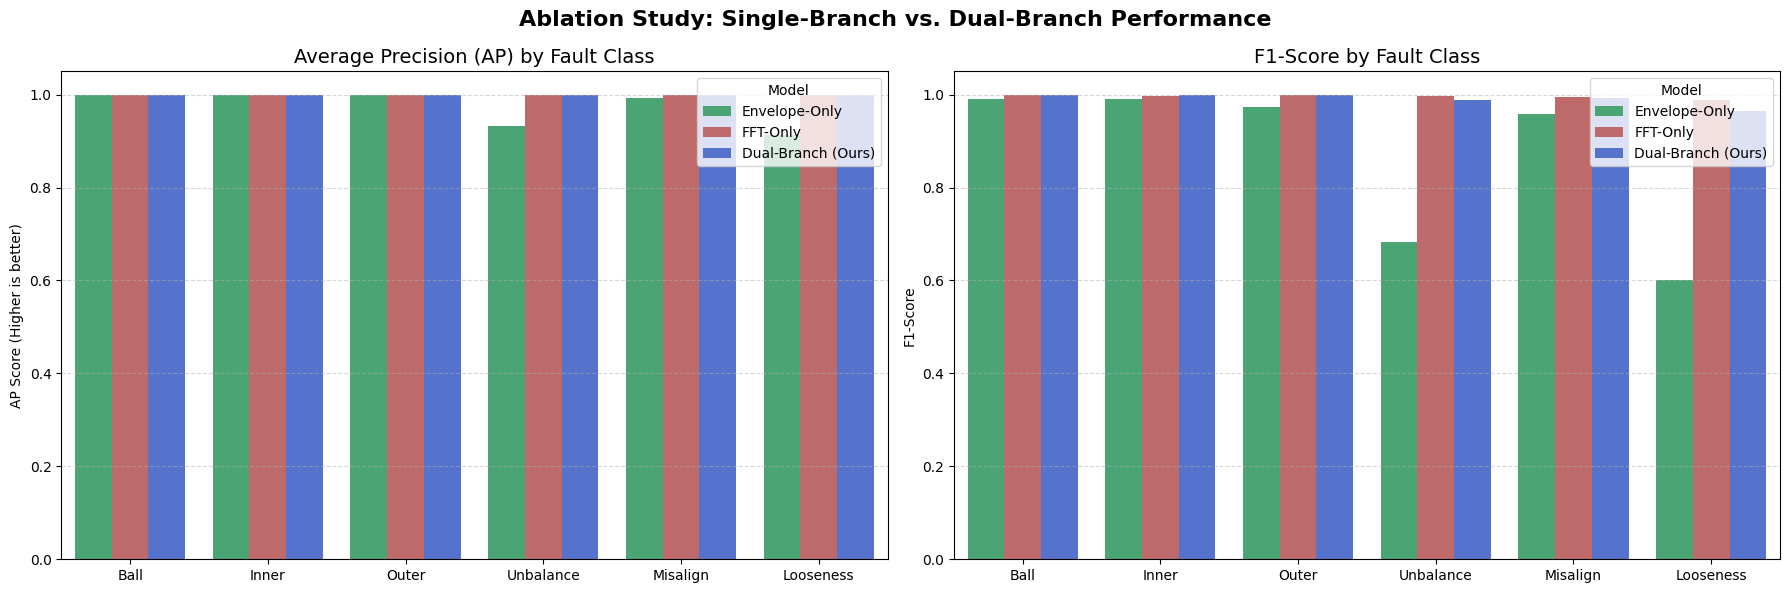


------------------------------
 TỔNG KẾT ĐỘ CHÍNH XÁC (GLOBAL EXACT MATCH) 
------------------------------
Envelope-Only       : 72.34%
FFT-Only            : 99.22%
Dual-Branch (Ours)  : 97.76%
Training Device: cuda

--- START TRAINING ---
Epoch 1/30 | Loss: 0.2200
Epoch 2/30 | Loss: 0.0638
Epoch 3/30 | Loss: 0.0327
Epoch 4/30 | Loss: 0.0239
Epoch 5/30 | Loss: 0.0164
Epoch 6/30 | Loss: 0.0079
Epoch 7/30 | Loss: 0.0080
Epoch 8/30 | Loss: 0.0105
Epoch 9/30 | Loss: 0.0073
Epoch 10/30 | Loss: 0.0109
Epoch 11/30 | Loss: 0.0119
Epoch 12/30 | Loss: 0.0047
Epoch 13/30 | Loss: 0.0069
Epoch 14/30 | Loss: 0.0057
Epoch 15/30 | Loss: 0.0050
Epoch 16/30 | Loss: 0.0076
Epoch 17/30 | Loss: 0.0053
Epoch 18/30 | Loss: 0.0062
Epoch 19/30 | Loss: 0.0044
Epoch 20/30 | Loss: 0.0031
Epoch 21/30 | Loss: 0.0056
Epoch 22/30 | Loss: 0.0067
Epoch 23/30 | Loss: 0.0056
Epoch 24/30 | Loss: 0.0051
Epoch 25/30 | Loss: 0.0035
Epoch 26/30 | Loss: 0.0083
Epoch 27/30 | Loss: 0.0050
Epoch 28/30 | Loss: 0.0019
Epoch 29/30 

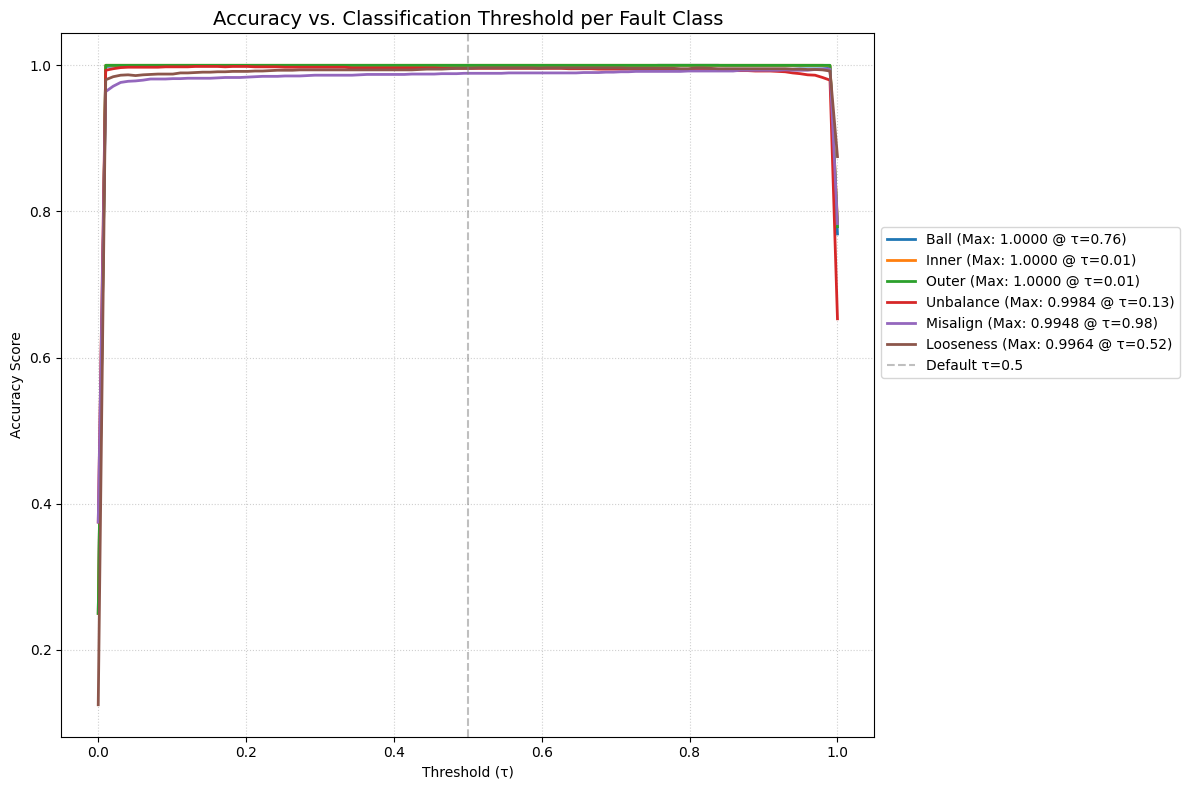


Class Name      | Precision  | Recall     | F1-Score   | Accuracy  
----------------------------------------------------------------------
Ball            | 0.9979     | 1.0000     | 0.9990     | 0.9995    
Inner           | 1.0000     | 1.0000     | 1.0000     | 1.0000    
Outer           | 1.0000     | 1.0000     | 1.0000     | 1.0000    
Unbalance       | 0.9986     | 0.9903     | 0.9944     | 0.9958    
Misalign        | 0.9717     | 1.0000     | 0.9856     | 0.9891    
Looseness       | 0.9754     | 0.9917     | 0.9835     | 0.9958    
----------------------------------------------------------------------
Global Exact Match Accuracy: 98.23%



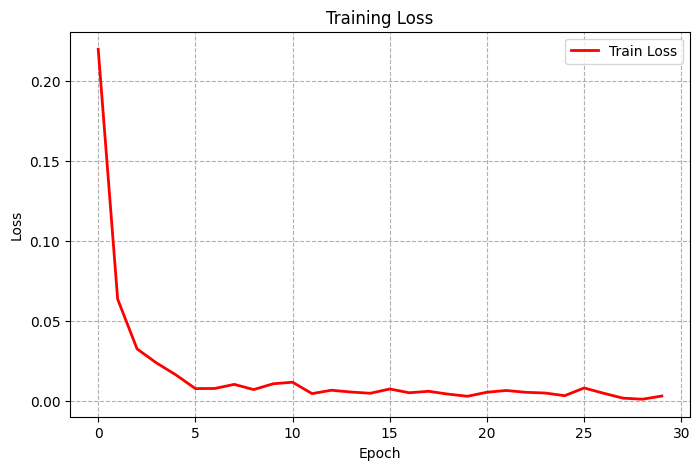

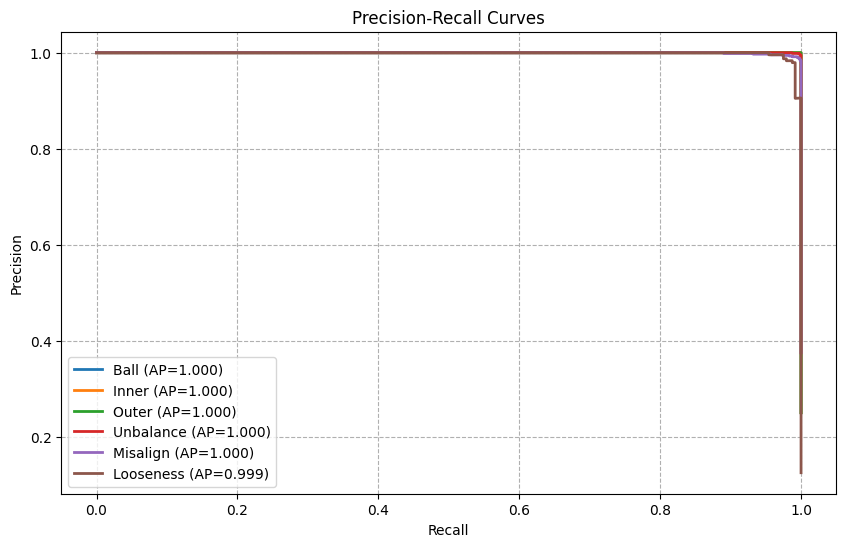

Calculating t-SNE...


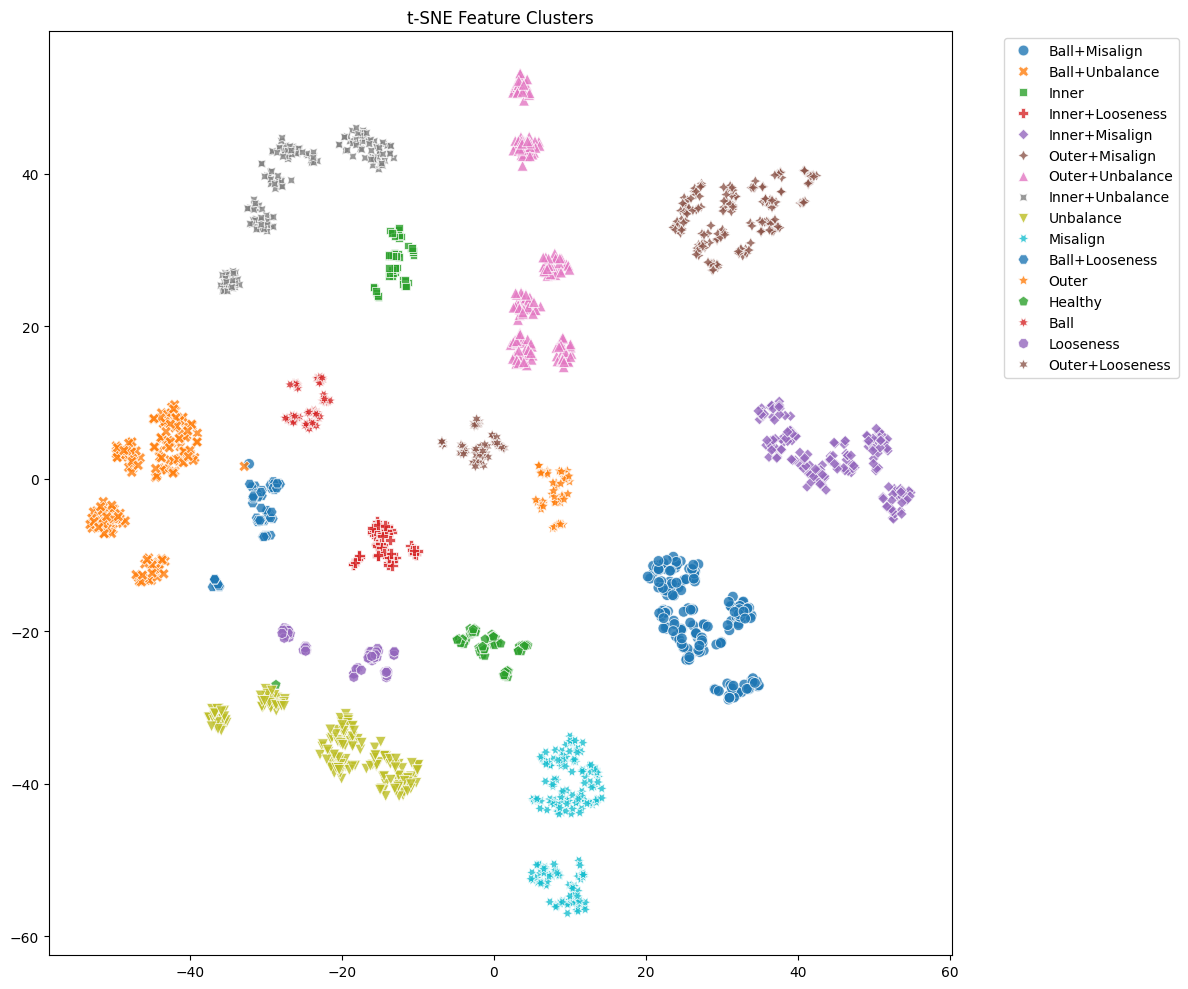

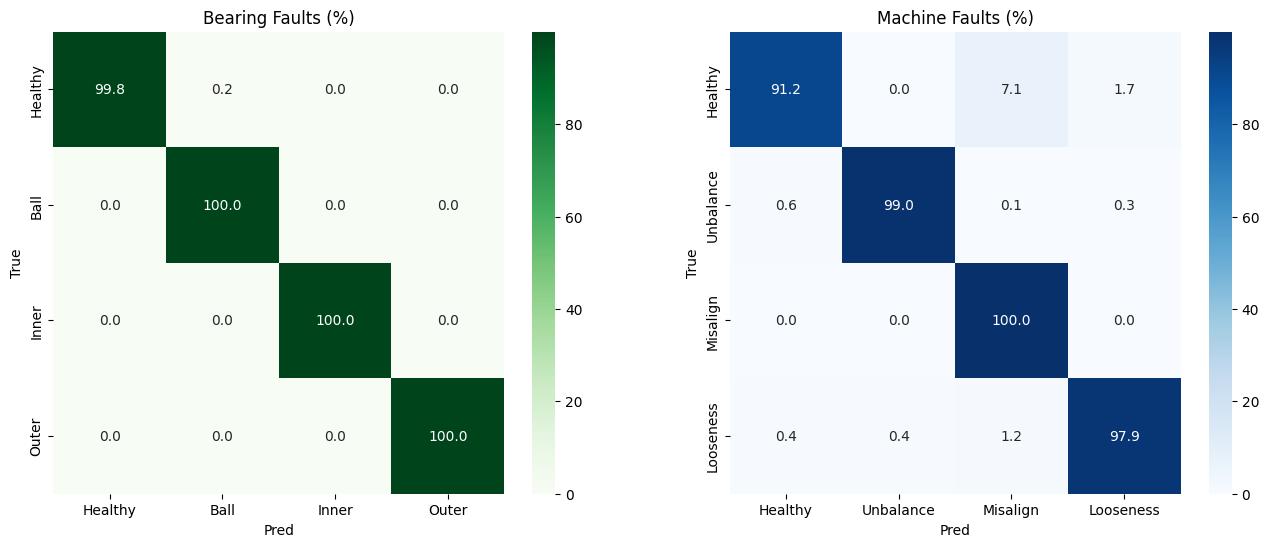


##################################################
 PREPARING MODELS FOR NOISE TEST 
##################################################
Training Clean Env-Only Model...
Training Device: cuda

--- START TRAINING ---
Epoch 1/50 | Loss: 0.3246
Epoch 2/50 | Loss: 0.1779
Epoch 3/50 | Loss: 0.1418
Epoch 4/50 | Loss: 0.1168
Epoch 5/50 | Loss: 0.0936
Epoch 6/50 | Loss: 0.0800
Epoch 7/50 | Loss: 0.0665
Epoch 8/50 | Loss: 0.0596
Epoch 9/50 | Loss: 0.0518
Epoch 10/50 | Loss: 0.0443
Epoch 11/50 | Loss: 0.0369
Epoch 12/50 | Loss: 0.0322
Epoch 13/50 | Loss: 0.0330
Epoch 14/50 | Loss: 0.0308
Epoch 15/50 | Loss: 0.0254
Epoch 16/50 | Loss: 0.0211
Epoch 17/50 | Loss: 0.0228
Epoch 18/50 | Loss: 0.0203
Epoch 19/50 | Loss: 0.0212
Epoch 20/50 | Loss: 0.0160
Epoch 21/50 | Loss: 0.0206
Epoch 22/50 | Loss: 0.0228
Epoch 23/50 | Loss: 0.0155
Epoch 24/50 | Loss: 0.0155
Epoch 25/50 | Loss: 0.0120
Epoch 26/50 | Loss: 0.0142
Epoch 27/50 | Loss: 0.0141
Epoch 28/50 | Loss: 0.0147
Epoch 29/50 | Loss: 0.0194
Epoch 30/5

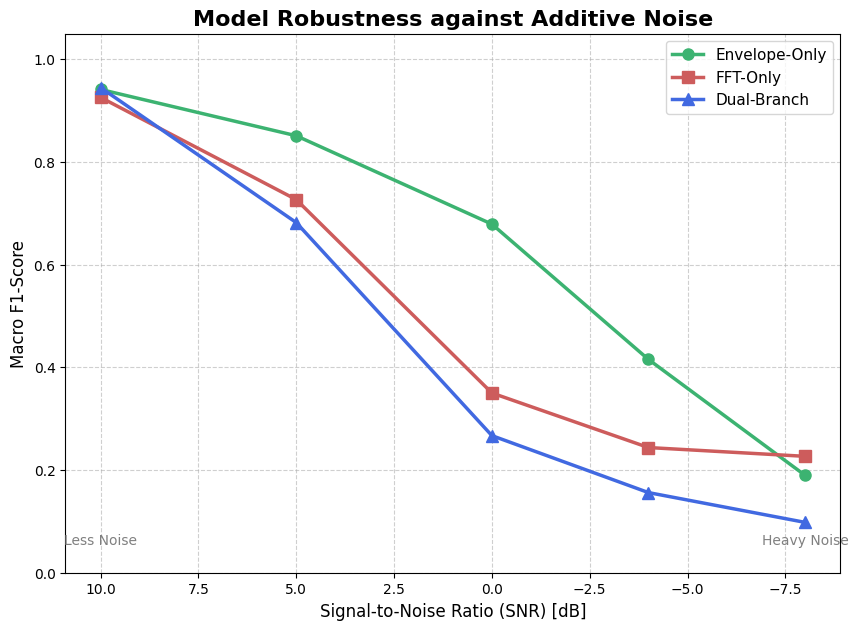

In [ ]:
# ======================================================================================
# 4. MAIN EXECUTION
# ======================================================================================
if __name__ == "__main__":
    CONFIG = {
        'root_dir': './UOS_Transfer',
        'bearing_name': 'bearing3', 
        'all_speeds': [600, 800, 1000, 1200, 1400, 1600],
        'batch_size': 32,
        'epochs': 30
    }
    
    # 1. Process Data
    if 'data_dict' not in locals():
        processor = UOSPreProcessor(CONFIG['root_dir'], CONFIG['bearing_name'])
        data_dict = processor.process_all_speeds(CONFIG['all_speeds'])
        
        # Split Stratified
        labels = data_dict['label']
        str_labels = ["".join(x.astype(int).astype(str)) for x in labels]
        X_env_tr, X_env_te, X_fft_tr, X_fft_te, y_tr, y_te = train_test_split(
            data_dict['env'], data_dict['fft'], labels,
            test_size=0.2, random_state=42, stratify=str_labels
        )
        
        train_ds = MultiLabelDataset(X_env_tr, X_fft_tr, y_tr)
        test_ds = MultiLabelDataset(X_env_te, X_fft_te, y_te)
        train_dl = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True)
        test_dl = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False)

    run_ablation_study(train_dl, test_dl, epochs=CONFIG['epochs'])

    # 2. Train & Report
    model = AttentionFusionModel()
    trainer = AdvancedTrainer(model, train_dl, test_dl)
    trainer.train(epochs=CONFIG['epochs'])
    trainer.generate_full_report()

    # --- ABLATION STUDY TEST NHIỄU ---
    print("\n" + "#"*50)
    print(" PREPARING MODELS FOR NOISE TEST ")
    print("#"*50)
    
    # 1. Train Model Envelope-Only (Clean)
    print("Training Clean Env-Only Model...")
    model_env = SingleBranchModel(mode='env')
    trainer_env = AdvancedTrainer(model_env, train_dl, test_dl) # Dùng lại train_dl sạch
    trainer_env.train(epochs=50) # Train nhanh 10 epoch
    
    # 2. Train Model FFT-Only (Clean)
    print("Training Clean FFT-Only Model...")
    model_fft = SingleBranchModel(mode='fft')
    trainer_fft = AdvancedTrainer(model_fft, train_dl, test_dl)
    trainer_fft.train(epochs=50)
    
    # 3. Train Model Dual-Branch (Clean) - Hoặc dùng model đã train ở bước trước
    print("Training Clean Dual-Branch Model...")
    model_dual = AttentionFusionModel()
    trainer_dual = AdvancedTrainer(model_dual, train_dl, test_dl)
    trainer_dual.train(epochs=50)
    
    # Gom 3 model vào dict
    models_dict = {
        'Envelope-Only': model_env,
        'FFT-Only': model_fft,
        'Dual-Branch': model_dual
    }
    
    # --- CHẠY TEST VỚI DỮ LIỆU NHIỄU ---
    # Lưu ý: Hàm này sẽ tự động load lại file raw, thêm nhiễu và test
    run_noise_robustness_test(models_dict, CONFIG)

In [3]:
def process_data_with_noise(processor, speeds_list, snr_db, fs_folder='SamplingRate_16000', max_segs=None):
    """
    Tạo dữ liệu (env, fft, label) với nhiễu cho cả train/test.
    Nếu max_segs=None thì lấy toàn bộ segment từ mỗi file.
    """
    data = {'env': [], 'fft': [], 'label': []}
    base_path = os.path.join(processor.root_dir, processor.bearing_type, fs_folder)
    bearing_map = {'B': 0, 'IR': 1, 'OR': 2}
    mech_map = {'U': 3, 'M': 4, 'L': 5}
    for speed in speeds_list:
        speed_path = os.path.join(base_path, f"RotatingSpeed_{speed}")
        if not os.path.exists(speed_path): continue
        files = [f for f in os.listdir(speed_path) if f.endswith('.mat')]
        for f_name in files:
            try:
                parts = f_name.split('_')
                mech_raw, bear_raw = parts[0], parts[1]
                if mech_raw == 'H': mech_key = 'H'
                elif mech_raw == 'L': mech_key = 'L'
                else: mech_key = mech_raw[0]
                label_vec = np.zeros(6, dtype=np.float32)
                if bear_raw in bearing_map: label_vec[bearing_map[bear_raw]] = 1.0
                if mech_key in mech_map: label_vec[mech_map[mech_key]] = 1.0
                mat = sio.loadmat(os.path.join(speed_path, f_name))
                raw = mat['Data'].flatten() if 'Data' in mat else mat['data'].flatten()
                sig = processor.angular_resampling(raw, 16000, speed)
                step = processor.window_size // 2
                n_segs = (len(sig) - processor.window_size) // step
                if max_segs is not None:
                    n_segs = min(n_segs, max_segs)
                for i in range(n_segs):
                    seg = sig[i*step : i*step + processor.window_size]
                    noisy_seg = add_white_gaussian_noise(seg, snr_db)
                    e, f = processor.extract_features(noisy_seg)
                    data['env'].append(e)
                    data['fft'].append(f)
                    data['label'].append(label_vec)
            except: pass
    return {k: np.array(v) for k, v in data.items()}

In [4]:
# --- 0.1: Tạo dữ liệu huấn luyện với nhiều mức nhiễu NGẪU NHIÊN ---
def process_data_with_random_noise(processor, speeds_list, snr_values, fs_folder='SamplingRate_16000', max_segs=None):
    """
    Tạo dataset (env, fft, label) mà mỗi segment được thêm noise với SNR được lấy ngẫu nhiên từ `snr_values`.
    """
    data = {'env': [], 'fft': [], 'label': []}
    base_path = os.path.join(processor.root_dir, processor.bearing_type, fs_folder)
    bearing_map = {'B': 0, 'IR': 1, 'OR': 2}
    mech_map = {'U': 3, 'M': 4, 'L': 5}
    for speed in speeds_list:
        speed_path = os.path.join(base_path, f"RotatingSpeed_{speed}")
        if not os.path.exists(speed_path): continue
        files = [f for f in os.listdir(speed_path) if f.endswith('.mat')]
        for f_name in files:
            try:
                parts = f_name.split('_')
                mech_raw, bear_raw = parts[0], parts[1]
                if mech_raw == 'H': mech_key = 'H'
                elif mech_raw == 'L': mech_key = 'L'
                else: mech_key = mech_raw[0]
                label_vec = np.zeros(6, dtype=np.float32)
                if bear_raw in bearing_map: label_vec[bearing_map[bear_raw]] = 1.0
                if mech_key in mech_map: label_vec[mech_map[mech_key]] = 1.0

                mat = sio.loadmat(os.path.join(speed_path, f_name))
                raw = mat['Data'].flatten() if 'Data' in mat else mat['data'].flatten()
                sig = processor.angular_resampling(raw, 16000, speed)
                step = processor.window_size // 2
                n_segs = (len(sig) - processor.window_size) // step
                if max_segs is not None:
                    n_segs = min(n_segs, max_segs)
                for i in range(n_segs):
                    seg = sig[i*step : i*step + processor.window_size]
                    # Lấy SNR ngẫu nhiên cho từng segment
                    snr_db = float(np.random.choice(snr_values))
                    noisy_seg = add_white_gaussian_noise(seg, snr_db)
                    e, f = processor.extract_features(noisy_seg)
                    data['env'].append(e)
                    data['fft'].append(f)
                    data['label'].append(label_vec)
            except: pass
    return {k: np.array(v) for k, v in data.items()}


# --- 0.2: Huấn luyện trên nhiễu ngẫu nhiên, đánh giá trên nhiễu cố định ---
def train_on_random_noise_and_test_fixed(model_constructors, train_snr_values, test_snr_list, config, epochs=25):
    """
    model_constructors: dict name -> function() that returns a fresh model instance
    train_snr_values: list of SNRs to sample randomly during training data creation
    test_snr_list: list of fixed SNRs to evaluate (e.g., [10, 5, 0, -4, -8])
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    processor = UOSPreProcessor(config['root_dir'], config['bearing_name'])

    # 1) Tạo dataset huấn luyện nhiễu ngẫu nhiên
    print(f"Generating RANDOM-NOISE training data (SNR choices: {train_snr_values}) ...")
    noisy_train_data = process_data_with_random_noise(processor, config['all_speeds'], train_snr_values, max_segs=50)

    # Split train/val
    labels = noisy_train_data['label']
    str_labels = ["".join(x.astype(int).astype(str)) for x in labels]

    X_env_tr, X_env_val, X_fft_tr, X_fft_val, y_tr, y_val = train_test_split(
        noisy_train_data['env'], noisy_train_data['fft'], labels,
        test_size=0.2, random_state=42, stratify=str_labels
    )

    train_ds = MultiLabelDataset(X_env_tr, X_fft_tr, y_tr)
    val_ds = MultiLabelDataset(X_env_val, X_fft_val, y_val)

    train_dl = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False)

    # Container để lưu kết quả test trên mỗi SNR cho từng model
    test_results = {name: [] for name in model_constructors.keys()}

    # 2) Huấn luyện từng model trên dữ liệu RANDOM-NOISE
    for name, constructor in model_constructors.items():
        print('\n' + '='*50)
        print(f"Training model on random-noise data: {name}")
        print('='*50)

        model = constructor().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCEWithLogitsLoss()

        # Training loop
        for ep in range(epochs):
            model.train()
            total_loss = 0
            for env, fft, lbl in train_dl:
                env, fft, lbl = env.to(device), fft.to(device), lbl.to(device)
                optimizer.zero_grad()
                loss = criterion(model(env, fft), lbl)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            if (ep+1) % 5 == 0 or ep == 0:
                print(f"Epoch {ep+1}/{epochs} | Loss: {total_loss/len(train_dl):.4f}")

        # Optional: validate on val_dl
        model.eval()
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for env, fft, lbl in val_dl:
                env, fft = env.to(device), fft.to(device)
                logits = model(env, fft)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()
                y_true_val.extend(lbl.cpu().numpy())
                y_pred_val.extend(preds.cpu().numpy())
        val_f1 = precision_recall_fscore_support(np.array(y_true_val), np.array(y_pred_val), average='macro', zero_division=0)[2]
        print(f"Validation Macro F1 (after training): {val_f1:.4f}")

        # 3) Đánh giá model trên danh sách SNR cố định (test_snr_list)
        for test_snr in test_snr_list:
            print(f"\n-> Generating fixed-SNR test set SNR={test_snr} dB ...")
            noisy_test = process_data_with_noise(processor, config['all_speeds'], test_snr, max_segs=20)
            ds_test = MultiLabelDataset(noisy_test['env'], noisy_test['fft'], noisy_test['label'])
            dl_test = DataLoader(ds_test, batch_size=config['batch_size'], shuffle=False)

            y_true, y_pred = [], []
            with torch.no_grad():
                for env, fft, lbl in dl_test:
                    env, fft = env.to(device), fft.to(device)
                    logits = model(env, fft)
                    probs = torch.sigmoid(logits)
                    preds = (probs > 0.5).float()
                    y_true.extend(lbl.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
            _, _, f1_macro, _ = precision_recall_fscore_support(np.array(y_true), np.array(y_pred), average='macro', zero_division=0)
            test_results[name].append(f1_macro)
            print(f"Model {name} | Test SNR={test_snr} dB | Macro F1 = {f1_macro:.4f}")

        # Free memory
        del model
        torch.cuda.empty_cache()

    # 4) Plot comparison across fixed test SNRs
    plt.figure(figsize=(10, 7))
    markers = ['o', 's', '^']
    colors = ['mediumseagreen', 'indianred', 'royalblue']
    for (name, scores), marker, color in zip(test_results.items(), markers, colors):
        plt.plot(test_snr_list, scores, marker=marker, linewidth=2.5, markersize=8, label=name, color=color)
    plt.gca().invert_xaxis()
    plt.title('Models trained on RANDOM noise | Tested on FIXED SNR (Macro F1)', fontsize=14)
    plt.xlabel('SNR [dB] (Lower -> Harder)')
    plt.ylabel('Macro F1-Score')
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(); plt.show()

    return test_results


Generating RANDOM-NOISE training data (SNR choices: [20, 15, 10, 5, 0, -4, -8]) ...

Training model on random-noise data: Envelope-Only
Epoch 1/30 | Loss: 0.4505
Epoch 5/30 | Loss: 0.1978
Epoch 10/30 | Loss: 0.1003
Epoch 15/30 | Loss: 0.0534
Epoch 20/30 | Loss: 0.0401
Epoch 25/30 | Loss: 0.0323
Epoch 30/30 | Loss: 0.0322
Validation Macro F1 (after training): 0.7897

-> Generating fixed-SNR test set SNR=10 dB ...
Model Envelope-Only | Test SNR=10 dB | Macro F1 = 0.8923

-> Generating fixed-SNR test set SNR=5 dB ...
Model Envelope-Only | Test SNR=5 dB | Macro F1 = 0.8722

-> Generating fixed-SNR test set SNR=0 dB ...
Model Envelope-Only | Test SNR=0 dB | Macro F1 = 0.8072

-> Generating fixed-SNR test set SNR=-4 dB ...
Model Envelope-Only | Test SNR=-4 dB | Macro F1 = 0.6885

-> Generating fixed-SNR test set SNR=-8 dB ...
Model Envelope-Only | Test SNR=-8 dB | Macro F1 = 0.4839

Training model on random-noise data: FFT-Only
Epoch 1/30 | Loss: 0.4659
Epoch 5/30 | Loss: 0.1597
Epoch 10/30 

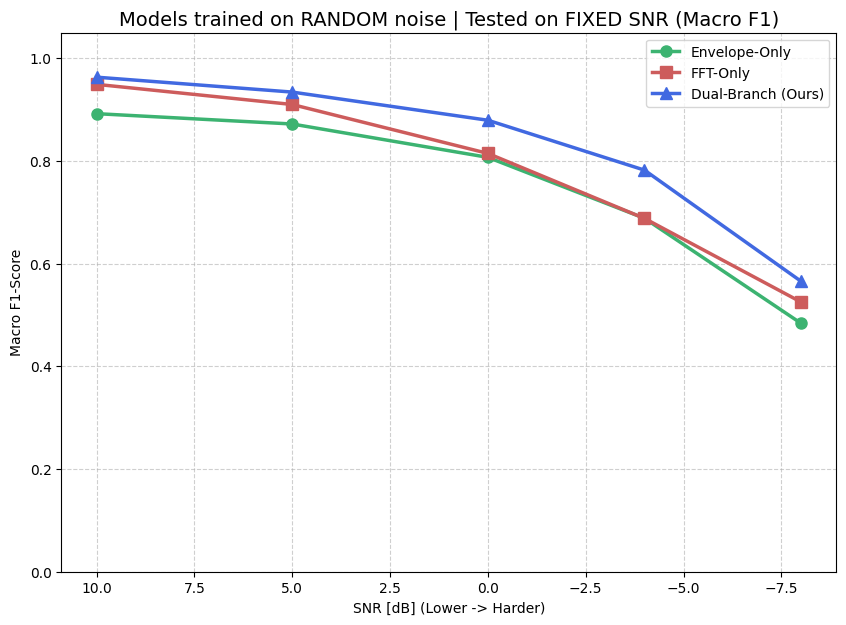


Summary of results:
Envelope-Only: ['0.8923', '0.8722', '0.8072', '0.6885', '0.4839']
FFT-Only: ['0.9494', '0.9102', '0.8149', '0.6883', '0.5253']
Dual-Branch (Ours): ['0.9634', '0.9344', '0.8795', '0.7823', '0.5657']


In [5]:
# --- RUN: Huấn luyện trên nhiễu NGẪU NHIÊN và test trên nhiễu CỐ ĐỊNH ---
model_constructors = {
    'Envelope-Only': lambda: SingleBranchModel(mode='env'),
    'FFT-Only': lambda: SingleBranchModel(mode='fft'),
    'Dual-Branch (Ours)': lambda: AttentionFusionModel()
}

# Phạm vi SNR dùng để sampling ngẫu nhiên trong train
train_snr_values = [20, 15, 10, 5, 0, -4, -8]
# Các mức SNR cố định để benchmark (test)
test_snr_list = [10, 5, 0, -4, -8]

# Chạy thử nghiệm (cẩn thận: có thể tốn thời gian/GPUs)
results_random_train = train_on_random_noise_and_test_fixed(model_constructors, train_snr_values, test_snr_list, CONFIG, epochs=30)

print('\nSummary of results:')
for k, v in results_random_train.items():
    print(f"{k}: {['{:.4f}'.format(x) for x in v]}")


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

def plot_metrics_vs_threshold(y_true, y_probs, target_names):
    """
    Vẽ biểu đồ sự thay đổi của Precision, Recall, F1-Score theo Threshold cho từng lỗi.
    """
    thresholds = np.linspace(0.01, 0.99, 100) # Thử 100 ngưỡng từ 0.01 đến 0.99
    num_classes = len(target_names)
    
    # Chuẩn bị lưới biểu đồ 2 hàng x 3 cột cho 6 class
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    fig.suptitle('Threshold Calibration: Precision, Recall, and F1-Score vs. Threshold', fontsize=18, fontweight='bold')

    # Lưu ngưỡng tối ưu để in ra màn hình
    best_thresholds = []

    for i in range(num_classes):
        precisions = []
        recalls = []
        f1_scores = []
        
        # Lấy dữ liệu của class thứ i
        y_true_cls = y_true[:, i]
        y_prob_cls = y_probs[:, i]
        
        # Quét qua từng ngưỡng
        for th in thresholds:
            y_pred_cls = (y_prob_cls >= th).astype(int)
            p, r, f, _ = precision_recall_fscore_support(y_true_cls, y_pred_cls, average='binary', zero_division=0)
            precisions.append(p)
            recalls.append(r)
            f1_scores.append(f)
            
        # Tìm ngưỡng cho F1 cao nhất
        best_idx = np.argmax(f1_scores)
        best_th = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]
        best_thresholds.append(best_th)
        
        # Vẽ biểu đồ
        ax = axes[i]
        ax.plot(thresholds, precisions, label='Precision', color='blue', linestyle='--')
        ax.plot(thresholds, recalls, label='Recall', color='green', linestyle='--')
        ax.plot(thresholds, f1_scores, label='F1-Score', color='red', linewidth=2.5)
        
        # Đánh dấu điểm tối ưu
        ax.axvline(x=best_th, color='black', linestyle=':', label=f'Best Thresh: {best_th:.2f}')
        ax.scatter(best_th, best_f1, color='red', s=80, zorder=5) # Điểm tròn đỏ
        ax.text(best_th + 0.02, best_f1 - 0.05, f"Max F1: {best_f1:.2f}", color='darkred', fontweight='bold')
        
        ax.set_title(f"Class: {target_names[i]}", fontsize=14)
        ax.set_xlabel("Threshold")
        ax.set_ylabel("Score")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1.05)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc='lower left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # In kết luận
    print("\n" + "="*50)
    print(" NGƯỠNG PHÂN LOẠI TỐI ƯU (DỰA TRÊN MAX F1-SCORE) ")
    print("="*50)
    for i, name in enumerate(target_names):
        print(f"Lỗi: {name:<12} -> Ngưỡng tối ưu: {best_thresholds[i]:.2f}")
    print("="*50)

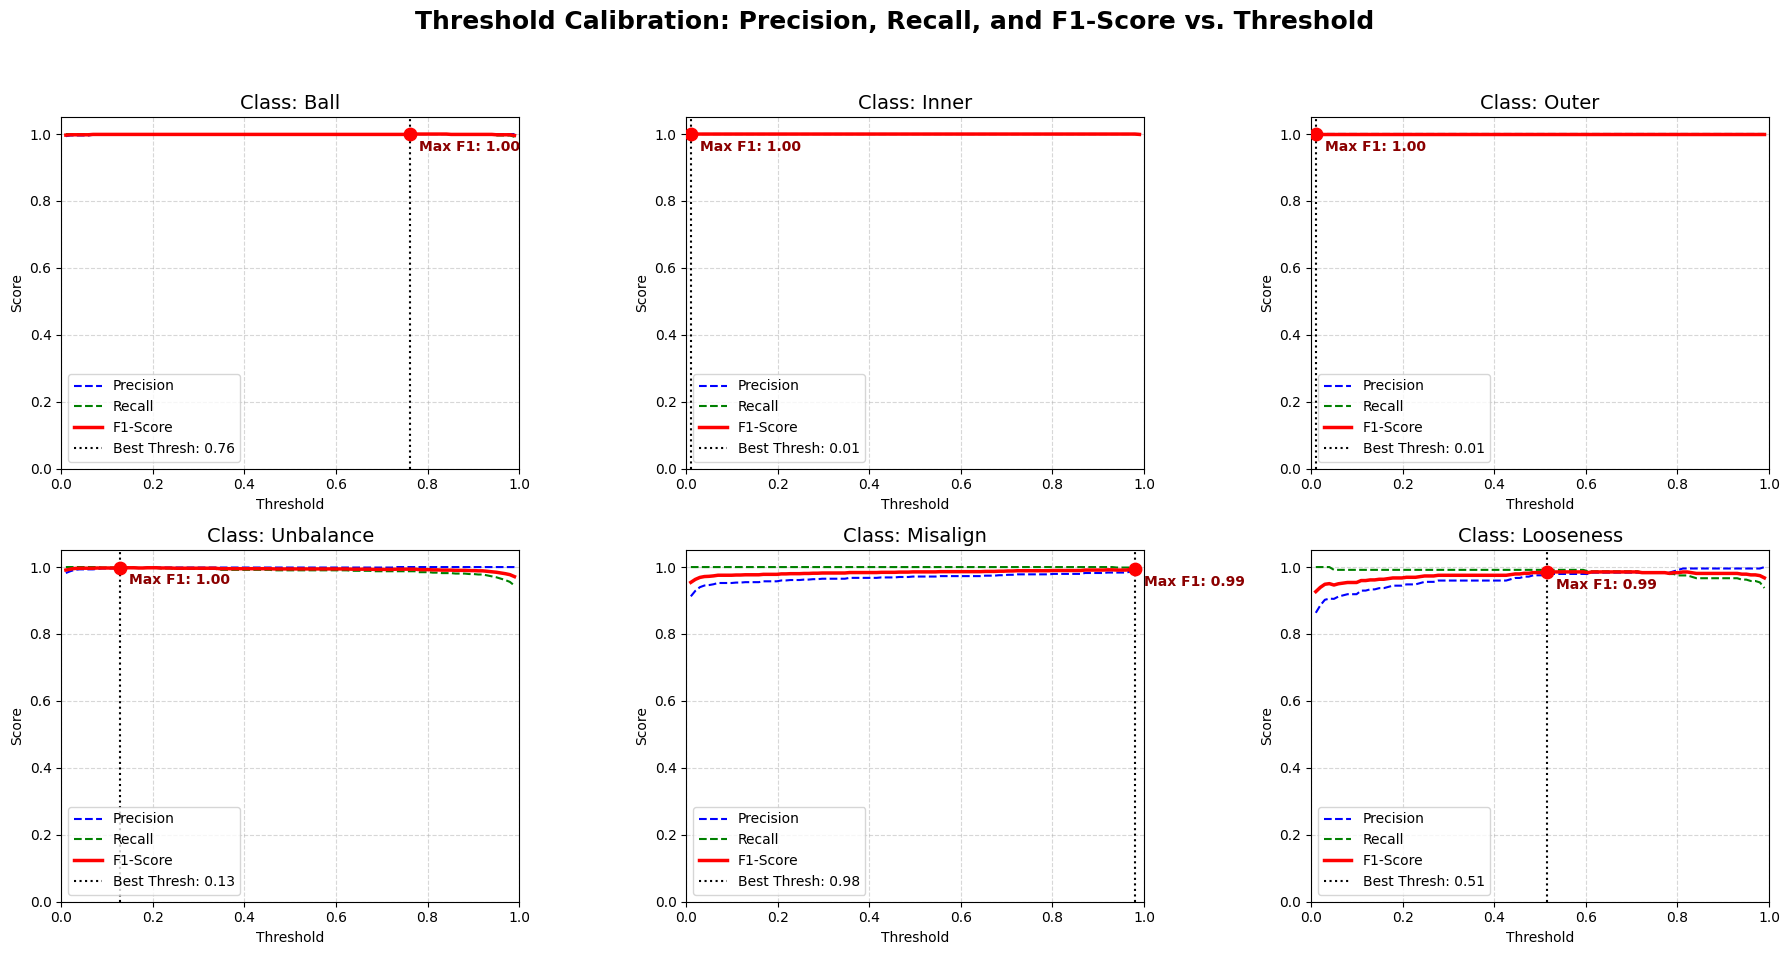


 NGƯỠNG PHÂN LOẠI TỐI ƯU (DỰA TRÊN MAX F1-SCORE) 
Lỗi: Ball         -> Ngưỡng tối ưu: 0.76
Lỗi: Inner        -> Ngưỡng tối ưu: 0.01
Lỗi: Outer        -> Ngưỡng tối ưu: 0.01
Lỗi: Unbalance    -> Ngưỡng tối ưu: 0.13
Lỗi: Misalign     -> Ngưỡng tối ưu: 0.98
Lỗi: Looseness    -> Ngưỡng tối ưu: 0.51


In [7]:
# Chạy ở cuối chương trình sau khi train xong
trainer.model.eval()
y_true, y_probs = [], []

with torch.no_grad():
    for env, fft, lbl in trainer.test_loader:
        env, fft = env.to(trainer.device), fft.to(trainer.device)
        logits = trainer.model(env, fft)
        probs = torch.sigmoid(logits)
        y_true.extend(lbl.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_probs = np.array(y_probs)

target_names = ['Ball', 'Inner', 'Outer', 'Unbalance', 'Misalign', 'Looseness']

# Gọi hàm vẽ
plot_metrics_vs_threshold(y_true, y_probs, target_names)

In [8]:
def run_noise_training_experiment(model_class, config, snr_list, mode=None, max_segs=20, epochs=10):
    """
    Train và test model trên dữ liệu nhiễu với từng mức SNR.
    model_class: AttentionFusionModel hoặc SingleBranchModel
    mode: 'env' hoặc 'fft' nếu là SingleBranchModel
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    for snr in snr_list:
        print(f"\n=== SNR = {snr} dB ===")
        processor = UOSPreProcessor(config['root_dir'], config['bearing_name'])
        # Tạo dữ liệu train/test đều có nhiễu
        data = process_data_with_noise(processor, config['all_speeds'], snr, max_segs=max_segs)
        labels = data['label']
        str_labels = ["".join(x.astype(int).astype(str)) for x in labels]
        X_env_tr, X_env_te, X_fft_tr, X_fft_te, y_tr, y_te = train_test_split(
            data['env'], data['fft'], labels,
            test_size=0.2, random_state=42, stratify=str_labels
        )
        train_ds = MultiLabelDataset(X_env_tr, X_fft_tr, y_tr)
        test_ds = MultiLabelDataset(X_env_te, X_fft_te, y_te)
        train_dl = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
        test_dl = DataLoader(test_ds, batch_size=config['batch_size'], shuffle=False)
        # Khởi tạo model
        if mode is not None:
            model = model_class(mode=mode)
        else:
            model = model_class()
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCEWithLogitsLoss()
        # Train
        for ep in range(epochs):
            model.train()
            for env, fft, lbl in train_dl:
                env, fft, lbl = env.to(device), fft.to(device), lbl.to(device)
                optimizer.zero_grad()
                loss = criterion(model(env, fft), lbl)
                loss.backward()
                optimizer.step()
        # Test
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for env, fft, lbl in test_dl:
                env, fft = env.to(device), fft.to(device)
                logits = model(env, fft)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()
                y_true.extend(lbl.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        _, _, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
        print(f"F1-Score (macro): {f1_macro:.4f}")
        results.append(f1_macro)
        # Giải phóng GPU
        del model
        torch.cuda.empty_cache()
    # Vẽ kết quả
    plt.figure(figsize=(8,5))
    plt.plot(snr_list, results, marker='o', linewidth=2.5)
    plt.gca().invert_xaxis()
    plt.title('F1-Score (Macro) khi Train/Test trên Nhiễu')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Macro F1-Score')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    return results


==== Train/Test trên nhiễu: Envelope-Only ====

=== SNR = 10 dB ===
F1-Score (macro): 0.9790

=== SNR = 5 dB ===
F1-Score (macro): 0.9683

=== SNR = 0 dB ===
F1-Score (macro): 0.9407

=== SNR = -4 dB ===
F1-Score (macro): 0.8585

=== SNR = -8 dB ===
F1-Score (macro): 0.5232


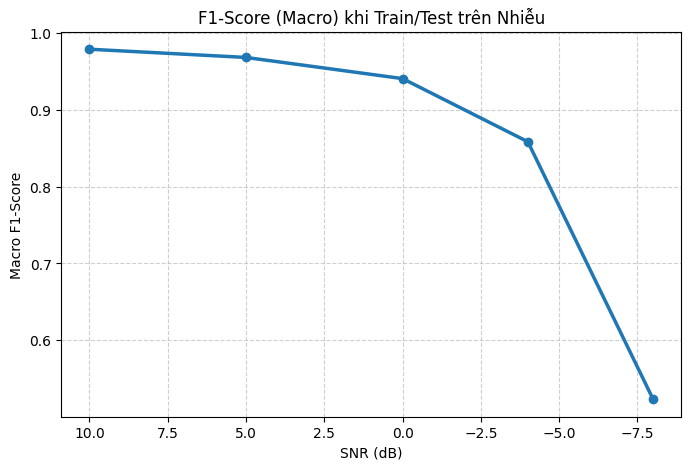


==== Train/Test trên nhiễu: FFT-Only ====

=== SNR = 10 dB ===
F1-Score (macro): 0.9993

=== SNR = 5 dB ===
F1-Score (macro): 0.9993

=== SNR = 0 dB ===
F1-Score (macro): 0.9947

=== SNR = -4 dB ===
F1-Score (macro): 0.9711

=== SNR = -8 dB ===
F1-Score (macro): 0.8126


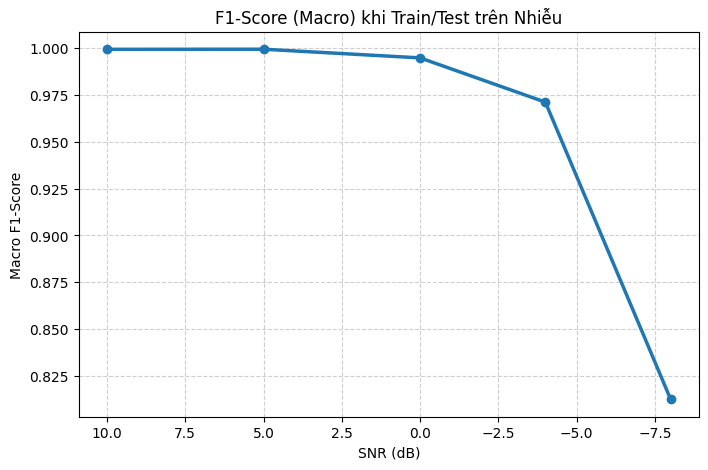


==== Train/Test trên nhiễu: Dual-Branch ====

=== SNR = 10 dB ===
F1-Score (macro): 0.9999

=== SNR = 5 dB ===


KeyboardInterrupt: 

In [ ]:
# Train và test trên nhiễu cho cả 3 mô hình
CONFIG = {
    'root_dir': './UOS_Transfer',
    'bearing_name': 'bearing3',
    'all_speeds': [600, 800, 1000, 1200, 1400, 1600],
    'batch_size': 32,
    'epochs': 50
}
snr_list = [10, 5, 0, -4, -8]

print("\n==== Train/Test trên nhiễu: Envelope-Only ====")
run_noise_training_experiment(SingleBranchModel, CONFIG, snr_list, mode='env', max_segs=200, epochs=50)

print("\n==== Train/Test trên nhiễu: FFT-Only ====")
run_noise_training_experiment(SingleBranchModel, CONFIG, snr_list, mode='fft', max_segs=200, epochs=50)

print("\n==== Train/Test trên nhiễu: Dual-Branch ====")
run_noise_training_experiment(AttentionFusionModel, CONFIG, snr_list, mode=None, max_segs=200, epochs=50)